In [ ]:
import os, shutil
if os.path.exists('/content/HMP_Dataset'):
  shutil.rmtree('/content/HMP_Dataset')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import zipfile
import os

def unzip(path):
  zfile = zipfile.ZipFile(path)
  files = []
  for name in zfile.namelist():
    (dirname, filename) = os.path.split(name)
    if not (dirname.endswith('MODEL') or filename.endswith('.m') or filename == 'MANUAL.txt' or filename == 'README.txt'):
      files.append(name)
      if filename == '':
        if not os.path.exists(dirname):
          os.makedirs(dirname)
      else:
        fd = open(name, 'wb')
        fd.write(zfile.read(name))
        fd.close()
  zfile.close()
  return files

files = unzip('/content/ADL_Dataset.zip')

print('files unzipped !')

files unzipped !


In [ ]:
import glob
directories = glob.glob("../content/HMP_Dataset/*")

data={}
activitydata={}
activity = 0
fileno = 0
x=np.empty((1,3))

for filepath in files:
  if not filepath.endswith('.txt'):
    if len(data) > 0:
      activitydata[activity] = data
      activity=activity+1
      fileno = 0
      data = {}
  else:
    data[fileno] = np.loadtxt(filepath, delimiter=' ')
    fileno = fileno+1

activitydata[activity] = data
print('Data loaded !', len(activitydata))

Data loaded ! 14


In [ ]:
print(len(activitydata[0]))
print(len(activitydata[1]))

12
102


In [ ]:
def sample(filedata, samplesize=32, overlapping=0.5):
  x = np.empty((1,samplesize*3))
  stepsize=int(samplesize*overlapping)
  for j in range(0,np.size(filedata, axis=0)-samplesize,stepsize):
    x = np.append(x, filedata[j:j+samplesize].reshape(1,samplesize*3), axis=0)
  return x[1:]

samplesize = 32
overlapping = 0.5
vectored_total_activity_data = {}
vectored_activity_data = {}
temp_vd = {}
total_data = np.empty((1,3*samplesize))

for i in range(len(activitydata)):
  vectored_data = np.empty((1,3*samplesize))
  for j in range(len(activitydata[i])):
    temp_vd[j] = sample(activitydata[i][j], samplesize, overlapping)
    vectored_data = np.append(vectored_data,temp_vd[j], axis = 0)
    
  vectored_total_activity_data[i] = vectored_data[1:]
  vectored_activity_data[i] = temp_vd
  total_data = np.append(total_data,vectored_data[1:], axis = 0)
  temp_vd = {}
total_data = total_data[1:]
  

print(vectored_total_activity_data[i].shape)

(5615, 96)


In [ ]:
from sklearn.cluster import KMeans

def histo(y_kmeans, n_clusters=480):
  histo = []
  for j in range(n_clusters):
    idx = np.where(y_kmeans[:] == j)
    histo.append(np.size(idx))
  return histo

def kmeanhistovector(data, activity_data, file_data,  n_clusters=480, k=None):
  feature_vector = []
  feature_label = []
  if (k==None):
    kmeans = KMeans(n_clusters).fit(data)    
  else:
    kmeans = k
  for i in range(14):
    for j in range(len(file_data[i])):
      pd = file_data[i][j]
      f_lable = kmeans.predict(pd)
      feature_label.append(i)
      feature_vector.append(histo(f_lable, n_clusters))
  return feature_vector, feature_label, kmeans

n_clusters = 480

fvd, fvl, km = kmeanhistovector(total_data, vectored_total_activity_data,vectored_activity_data,n_clusters)

In [ ]:
from sklearn.ensemble.forest import RandomForestClassifier

clf=RandomForestClassifier(n_estimators=30, max_depth=16)
clf.fit(fvd, fvl)
p=clf.predict(fvd)

count=0
for i in range(0,len(fvl)):
  count+=1 if p[i]==fvl[i] else 0
print(count/len(fvl))

0.9106078665077473


In [ ]:
from random import randint
from sklearn.metrics import confusion_matrix

def getTestData(vectored_activity_data):
  test_vector_data = {}
  test_vector = {}
  for i in range(14):
    x = randint(0,(len(vectored_activity_data[i])//3)*2)
    for j in range(x, x+len(vectored_activity_data[i])//3):
      test_vector[j-x] = vectored_activity_data[i][j]
    test_vector_data[i] = test_vector
    test_vector={}
  return test_vector_data

confision_matrix = []
labels = ['Brush_teeth', 'Climb_stairs', 'Comb_hair', 'Descend_stairs', 'Drink_glass', 'Eat_meat', 'Eat_soup', 'Getup_bed', 'Liedown_bed', 'Pour_water', 'Sitdown_chair', 'Standup_chair', 'Use_telephone', 'Walk']
score = []
for t in range(3):
  vad = getTestData(vectored_activity_data)
  test_fvd, test_fvl, km = kmeanhistovector(total_data,vectored_total_activity_data,vad,n_clusters, km)

  p=clf.predict(test_fvd)

  count=0
  for i in range(0,len(test_fvl)):
    count+=1 if p[i]==test_fvl[i] else 0
  score.append(  count/len(test_fvl))
  
  cm = confusion_matrix(test_fvl, p)
  confision_matrix.append(cm)
  
print('Mean Accuracy for 3 runs: ', np.mean(score))
print(confision_matrix[0])
print(confision_matrix[1])
print(confision_matrix[2])


Mean Accuracy for 3 runs:  0.9106280193236715
[[ 4  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 34  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 13  0  0  0  1  0  0  0  0  0  0]
 [ 0  0  0  0 33  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 33  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  4  0  3  1  0  0]
 [ 0  0  0  0  0  0  0  0  0 33  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 33  0  0  0]
 [ 0  0  0  0  0  0  0  1  0  0 10 23  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  1  0  3  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 33]]
[[ 4  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 34  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  7  0  0  0  0  0  0  0  3  0  0  0]
 [ 0  0  0 13  0  0  0  1  0  0  0  0  0  0]
 [ 0  0  0  0 33  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0 

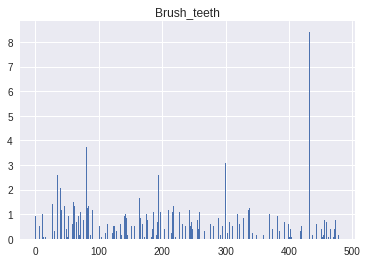

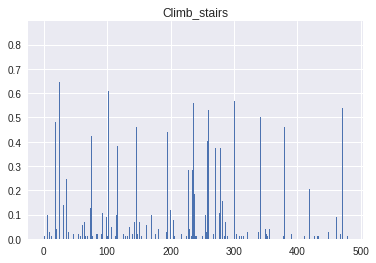

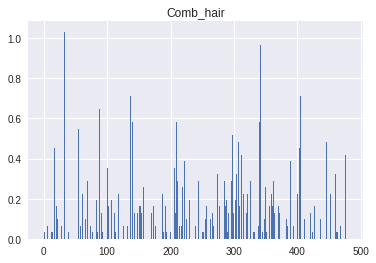

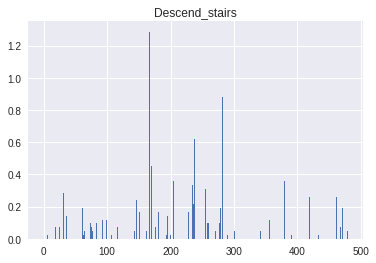

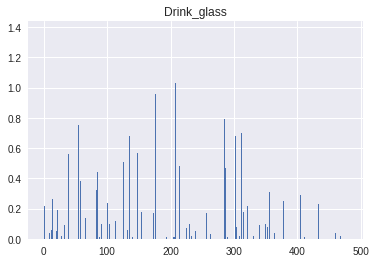

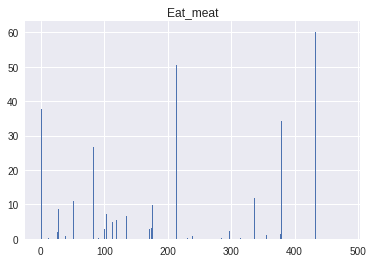

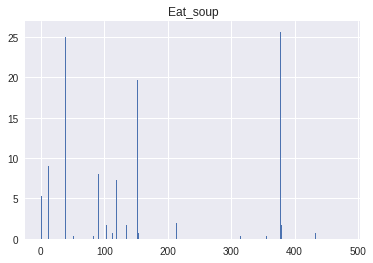

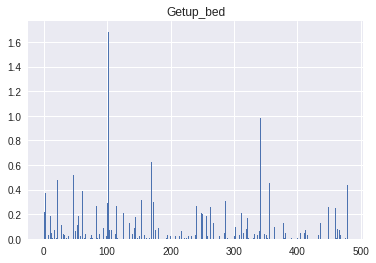

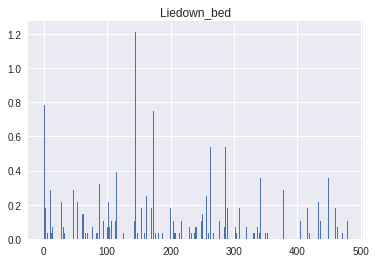

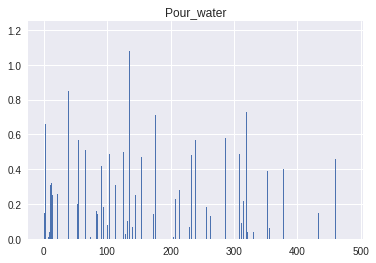

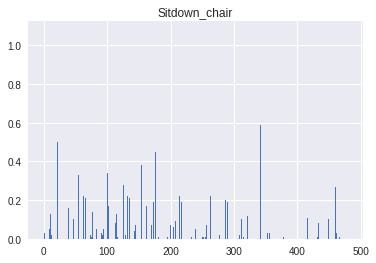

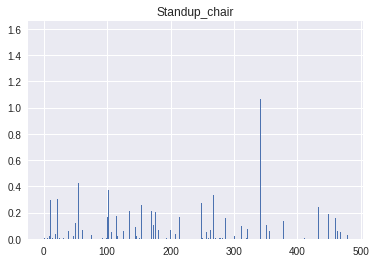

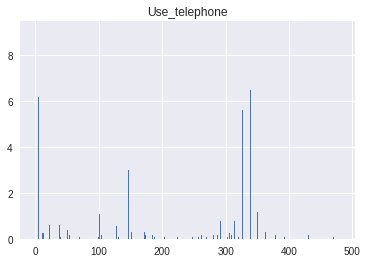

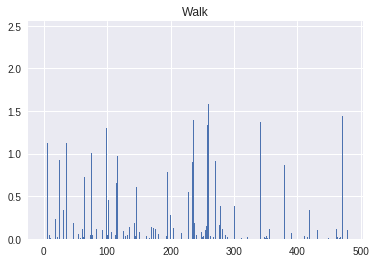

In [ ]:
meanValuesForHistogram=[]
k=0
for i in range(14):
  a = []
  for j in range(len(activitydata[i])):
    b = np.asarray(fvd[k])
    a.append(b)
    k=k+1
  a = np.asarray(a)
  meanValuesForHistogram.append(np.mean(a, axis=0))

for i in range(len(meanValuesForHistogram)):
  fig, ax = plt.subplots()
  ax.set_title(labels[i])
  ax.bar(range(len(meanValuesForHistogram[i])), meanValuesForHistogram[i])
